<a href="https://colab.research.google.com/github/Junoflows/Hands_on_ML/blob/main/Chapter_14_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%BB%B4%ED%93%A8%ED%84%B0_%EB%B9%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Chapter 14 합성곱 신경망을 사용한 컴퓨터 비전

#### 주요 내용
+ CNN의 구성요소
+ TF, keras 를 이용한 CNN 구현
+ CNN 모델 소개
+ Object detection
+ semantic segmentation

## 14.1 시각 피질 구조

+ 시각피질 안의 많은 뉴런이 작은 국부수용장(local receptive field)를 가짐
+ 합성곱 신경망으로 발전

## 14.2 합성곱 층(Convolutional layer)

+ CNN 의 가장 중요한 구성 요소
+ 첫 번째 은닉층에서는 저수준 특성을 학습하고, 상위층으로 갈 수록 고수준 특성을 학습
+ 이런 계층적 구조가 CNN 이 이미지 인식에 잘 작동하는 이유 중 하나

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-05a.png' width = 50%>

+ Edge pixel data를 충분히 활용하기 위해 Zero padding 사용

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-06.png' width = 50%>

+ 스트라이드를 이용해 차원축소 - 모델의 계산 복잡도를 크게 낮춤

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-07.png' width = 50%>

### 14.2.1 필터 (합성곱 커널)

+ 입력 뉴런에 사용될 가중치 역할
+ 층의 전체 뉴런에 적용된 하나의 필터는 하나의 특성 맵을 만듦

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-08.png' width = 50% >

@ 수직 필터는 수직선을 강조하고 수평 필터는 수평선을 강조하고 나머지는 희미해짐 <br/>
@ 각각이 하나의 특성맵이 됨

### 14.2.2 여러 가지 특성 맵 쌓기

#### 특성 맵
+ 합성곱 층은 여러가지 필터를 가지고 각 필터마다 하나의 특성 맵을 출력
+ 하나의 필터에 포함된 모든 뉴런은 동일한 가중치와 편향을 사용
+ 필터마다 사용되는 가중치와 편향을 다름
+ 즉 하나의 합성곱 층이 입력에 여러 필터를 동시에 적용하여 여러 특성을 감지

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-09.png' width = 50% >

#### 컬러 채널
+ 입력 이미지가 컬러인 경우 3개 채널, 흑백인 경우 1개의 채널 사용

#### 뉴런의 출력값

+ 입력에 대한 가중치 합과 편향을 더한 값

$
z_{i,j,k} = b_k + \sum_{u=0}^{f_h-1} \sum_{v=0}^{f_w-1} \sum_{k'=0}^{f_{n'}-1} x_{i',j',k'} \times w_{u,v,k',k} \quad \text{여기서} \left\{ \begin{array}{ll} i' = i \times s_h + u \\ j' = j \times s_w + v \end{array} \right.
$


<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-09d.png' width = 50% >


### 14.2.3 텐서플로 구현

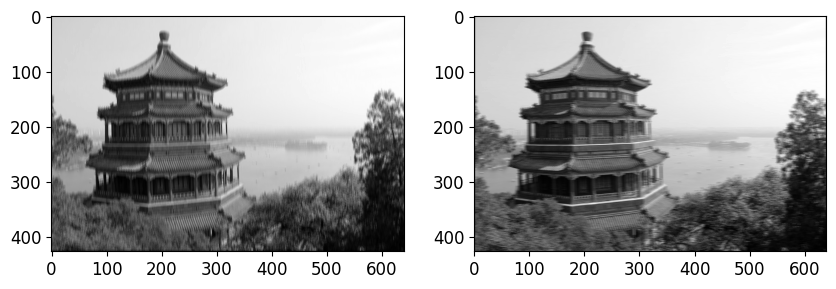

In [2]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 필터 2개 생성
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직커널
filters[3, :, :, 1] = 1  # 수평커널

outputs = tf.nn.conv2d(images, filters, strides = 1, padding = 'SAME')

fig, axes = plt.subplots(1,2,figsize = (10, 10))
axes[0].imshow(outputs[0, :, :, 0], cmap = 'gray')
axes[1].imshow(outputs[0, :, :, 1], cmap = 'gray')
plt.show()

## 14.3 풀링 층

+ 계산량과 메모리 사용량을 줄이면서 과대적합의 위험을 줄여주는 용도
+ 가중치를 사용하지 않고 stride 를 사용하여 차원을 축소


### max pooling layer

+ 커널에 속한 값 중에서 가장 큰 값만 상위 층으로 전달
+ stride 로 상위 층의 뉴런 수를 줄임

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-10.png' width = 50% >

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-11.png' width = 50%>

특징
+ 파라미터 수를 획기적으로 줄여 계산량과 메모리 사용량을 줄여줌
+ 많은 정보를 잃게 됨 (그래도 잘 작동함)
+ 작은 변화에도 어느 정도의 불변성이 보장됨

In [3]:
tf.keras.layers.MaxPool2D(pool_size=2)

### average pooling layer

+ 풀링 커널 구역 내의 평균값 활용
+ max pooling layer 에 비해 성능이 떨어짐

In [4]:
tf.keras.layers.AvgPool2D(pool_size=2)

### global average pooling layer

+ 각 특성 맵의 평균을 계산
+ 샘플의 각 특성 맵에 대해 하나의 숫자 출력
+ 매우 많은 정보를 잃게 되지만 출력층에서 유용하게 활용될 수 있음

In [5]:
tf.keras.layers.GlobalAvgPool2D()

### 깊이별 max/average pooling layer

+ 각 특성 맵에 대해 공간 별로 최대 / 평균 계산하는 것 대신 지정된 수 만큼의 특성 맵에 대해 최대 / 평균을 계산하는 풀링 층
+ 다양한 특성에 대한 불변성을 학습할 수 있음 (두께, 밝기, 왜곡, 색상 등)

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-12.png' width = 50%>

+ 케라스에서 지원하지 않지만 쉽게 구현 가능

In [6]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

## 14.4 CNN 구조

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-03.png' width = 70%>

합성곱 층에서 첫 번째 합성곱 층을 제외하고는 큰 커널을 사용하지 않음
  + 5x5 커널의 합성곱 층 대신 3x3 커널 2개를 사용
  + 파라미터 계산량이 적고 일반적으로 더 좋은 성능을 냄

첫 번째 합성곱 층은 큰 크기의 커널을 사용
+ 너무 많은 정보를 잃지 않고 공간 방향 차원을 줄일 수 있음

#### 케라스 예제 : 패션 MNIST

In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation = 'relu', padding = 'same', input_shape = [28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'),
    keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'),
    keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax')
    ])

### 14.4.1 LeNet-5

@ 가장 널리 알려진 CNN 구조로 MNIST 데이터에 사용됨

<img src= 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-14a.png' width =70%>

<img src = 'https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-18-12-52-17.png' width = 70% >

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-16.gif' width = 60%>

### 14.4.2 AlexNet

2012년 이미지넷 우승 모델
+ top-5 에러율 17%

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-15a.png' width = 70%>

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-15b.png' width = 70%>

과대적합 완화방안
+ F9, F10 에서 드롭아웃 50%
+ 데이터 증강 @ 랜덤하게 이미지를 이동, 수평으로 뒤집기, 밝기조절

정규화 : LRN(local response normalization)
+ 뉴런의 출력값을 보다 경쟁적으로 만드는 정규화
+ 어떤 특성맵에 속한 뉴런의 활성화 함수의 반환값이 클 경우, 주변 특성맵의 같은 위치에 있는 활성화 함수값을 작게 만듦
+ 각 특성지도를 보다 특별하게 만들어 다양한 특성을 탐색할 수 있음
+ C1, C3의 ReLU 단계 후에 수행


$
b_{i} = a_{i} \left( k + \alpha \sum_{j=\max(0, i-n/2)}^{j=\min(N-1, i+n/2)}a_{j}^2 \right)^{-\beta}
$

@ 배치정규화 등장 이후 사용 빈도 감소

### 14.4.3 GoogLeNet

2014년 이미지넷 우승 모델
+ top-5 에러율 7%

<img src = 'https://mblogthumb-phinf.pstatic.net/MjAxODEwMTNfMTI0/MDAxNTM5NDEyNjIyMzg0.y1z76GN3mP2yfiYyU2lgI5emhqY10EFrcPDFo1B3bBIg.6i7avVtaDGneOB6MmNon1mVTYiW1EBxTd9PNiSzebS8g.PNG.siniphia/googlenet.PNG?type=w800' width = 70%>

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-18.png' width = 50%>

인셉션 모듈이라는 서브 네트워크 활용
+ 3 x 3 + 1(S) : 3x3 커널, stride = 1
+ 입력 신호가 복사되어 4개의 다른 층을 통과
+ 두 번째 합성곱 층에서 서로 다른 크기의 패턴을 파악

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-19.png' width = 50% >

@ 처음 두 층은 계산량을 줄이기 위해 이미지의 높이와 너비를 1/4로 줄임

많은 정보를 유지하기 위해 커널 크기가 큼

9개의 인셉션 모듈을 통과하고 중간에 속도와 차원축소를 위해 max 풀링 층을 추가

최종적으로 1000개 클래스 중 예측

### 14.4.4 VGGNET

2014년 이미지넷 준우승 모델
+ top-5 에러율 8~10%
+ 2~3개 합성곱 층 + 풀링층 의 단순 반복
+ 총 16~19개 합성곱 층 사용
+ 다수의 3x3 커널을 사용

<img src = 'https://miro.medium.com/v2/resize:fit:1400/1*5lfBlfwmlsfV_AseNoL95g.png' width = 70%>

### 14.4.5 ResNet

2015년 이미지넷 우승 모델
+ top-5 에러율 3.6%

152개의 층으로 구성된 극도로 깊은 CNN 사용
+ 더 적은 파라미터를 사용해 점점 깊은 네트워크로 모델을 구성하는 트랜드의 시작

#### 잔차 유닛(RU)
+ 많은 층으로 인한 계산을 줄이기 위해 사용
+ skip-connection
  + 아직 학습되지 않은 상황에서 네트워크는 훈련을 시작
  + 입력 신호가 전체 네트워크에 보다 많은 영향을 미침
  + 과적합을 방지하는 효과

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-20.png' width = 50%>

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-21.png' width = 50%>

구조

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-22.png' width = 50%>

### 14.4.6 Xception

+ 2016년 케라스의 창시자 프랑수아 숄레가 제안
+ GoogLeNet과 ResNet의 합성 버전
+ 인셉션 모듈 대신 깊이별 분리 합성곱 층 사용


#### 분리 합성곱 층
+ 공간별 패턴 인식 층과 채널 사이 패턴 인식 층을 분리하여 모델링
+ 일반 합성곱 층보다 파라미터, 메모리, 연산을 더 적게 사용하고 성능은 더 높음

@ 보통 2개의 일반 합성곱 층으로 시작한 후 깊이별 분리 합성곱 층 적용

@공간별 패턴인식 : 형태 인식 (입력 특성 맵마다 한 개만 탐색)

@채널 사이 패턴인식 : 구체적인 패턴 인식 (눈, 코 입 등)


<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-24b.png' width = 50%>

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-24c.png' width = 70%>

### 14.4.7 SENet

+ 2017년 이미지넷 우승 모델
  + top-5 에러율 2.25%
+ GoogLeNet, ResNet 합성 버전
+ 인셉션 모듈과 잔차유닛에 SE block 을 추가하여 성능을 향상

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-25.png' width = 50%>

#### SE block 기능
+ 입력된 특성 맵을 대상으로 깊이별 패턴 특성 분석
+ 패턴 특성들을 파악한 후 출력값 보정

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-26.png' width = 70%>

#### SE block 구조
+ 전역평균 풀링층 -> 밀집층 -> 밀집충
+ 첫 번째 밀집층 : 뉴런 수를 1/16 으로 줄임
  + 특성 맵들 사이의 연관성 학습 강제
+ 두 번째 밀집층 : 뉴런수를 정상화 시킴
  + 학습된 연관성을 이용하여 입력 특성 맵을 보정할 가중치 출력

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-27.png' width = 30%>

## 14.5 케라스를 사용해 ResNet-34 CNN 구현

잔차 유닛 구현

In [8]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, kernel_size=3, strides=strides,
                                padding="SAME", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, kernel_size=3, strides=strides,
                                padding="SAME", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, kernel_size=3, strides=strides,
                                    padding="SAME", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
    # main_layers
      Z = inputs
      for layer in self.main_layers:
          Z = layer(Z)

      # skip_layers
      skip_Z = inputs
      for layer in self.skip_layers:
          skip_Z = layer(skip_Z)
      return self.activation(Z + skip_Z)

In [9]:
# model = keras.models.Sequential()
# model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
#                               padding="SAME", use_bias=False))
# model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Activation("relu"))
# model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
# prev_filters = 64
# for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
#     strides = 1 if filters == prev_filters else 2
#     model.add(ResidualUnit(filters, strides=strides))
#     prev_filters = filters
# model.add(keras.layers.GlobalAvgPool2D())
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(10, activation="softmax"))

## 14.6 케라스 제공하는 사전훈련된 모델 사용하기

많은 모델이 keras.applications 에서 기본 제공
+ ResNet 모델 변종
+ Inception-v3, Xception 등 GoogLeNet 모델 변종
+ VGGNet 모델 변종
+ MobileNet, MobileNetV2 등 모바일 전용 모델

In [10]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
# ResNet50은 입력 크기가 (224, 224) 이므로 resize 해야됨
images_resized = tf.image.resize(images, [224, 224])

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [ ]:
Y_proba = model.predict(inputs)

1/1 [==============================] - 5s 5s/step


In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=5)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%
  n02980441 - castle       3.16%
  n03028079 - church       1.00%

Image #1
  n03530642 - honeycomb    49.81%
  n13040303 - stinkhorn    33.96%
  n02206856 - bee          4.35%
  n11939491 - daisy        3.23%
  n12985857 - coral_fungus 2.66%



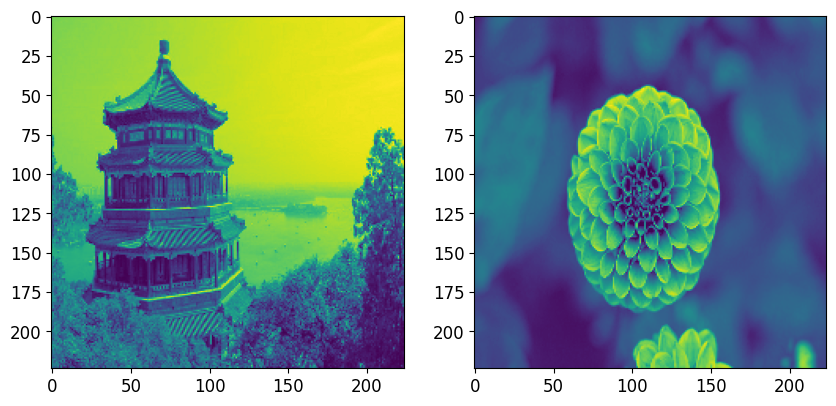

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].imshow(inputs[0, :, :, 1])
ax[1].imshow(inputs[1, :, :, 1])

## 14.7 사전훈련된 모델을 사용한 전이학습

이미지넷에 없는 이미지를 분류하고자 하는 경우 사용

In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits['train'].num_examples # 3670
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [ ]:
def preprocess(image, label, randomize=False):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
# 사전훈련된 층의 가중치 동결하기
for layer in base_model.layers:
    layer.trainable = False

# 컴파일 후 훈련 시작
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs = 5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 26s 205ms/step - loss: 1.5242 - accuracy: 0.7820 - val_loss: 1.5655 - val_accuracy: 0.8185
Epoch 2/5
86/86 [==============================] - 15s 172ms/step - loss: 0.9499 - accuracy: 0.8808 - val_loss: 1.3181 - val_accuracy: 0.8475
Epoch 3/5
86/86 [==============================] - 15s 176ms/step - loss: 0.5628 - accuracy: 0.9175 - val_loss: 1.3374 - val_accuracy: 0.8566
Epoch 4/5
86/86 [==============================] - 14s 168ms/step - loss: 0.3503 - accuracy: 0.9408 - val_loss: 1.6165 - val_accuracy: 0.8203
Epoch 5/5
86/86 [==============================] - 15s 169ms/step - loss: 0.2890 - accuracy: 0.9459 - val_loss: 1.3114 - val_accuracy: 0.8494


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

# 재 컴파일 후 훈련 시작
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs = 5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 64s 539ms/step - loss: 0.3716 - accuracy: 0.8841 - val_loss: 0.5729 - val_accuracy: 0.8367
Epoch 2/5
86/86 [==============================] - 45s 527ms/step - loss: 0.0777 - accuracy: 0.9775 - val_loss: 0.2735 - val_accuracy: 0.9274
Epoch 3/5
86/86 [==============================] - 44s 514ms/step - loss: 0.0202 - accuracy: 0.9935 - val_loss: 0.4022 - val_accuracy: 0.9111
Epoch 4/5
86/86 [==============================] - 45s 520ms/step - loss: 0.0224 - accuracy: 0.9924 - val_loss: 0.4247 - val_accuracy: 0.9129
Epoch 5/5
86/86 [==============================] - 45s 519ms/step - loss: 0.0280 - accuracy: 0.9931 - val_loss: 0.4417 - val_accuracy: 0.9183


## 14.8 분류와 위치 추정

위치추정은 회귀 모델로 구현 가능
+ bounding box 그리기
+ 중심, 높이, 가로, 세로 총 4개 좌표를 예측
+ 앞서 사용된 분류 모델에 4개 뉴런을 출력층으로 추가하면 됨

In [ ]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation = 'softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs = base_model.input, outputs = [class_output, loc_output])
model.compile(loss = ['sparse_categorical_crossentropy', 'mse'],
              loss_weights = [0.8, 0.2], optimizer = optimizer, metrics = ['accuracy'])

### bounding box 레이블링

+ bounding box 위치를 (지도)학습 시키려면 모든 이미지에 레이블이 추가되어야 함
+ 어려우면서 고비용이 요구됨

#### boundind box 레이블링 도구

오픈소스 프로그램
+ VGG Image Annotation
+ LabelImg
+ OpenLabeler
+ ImgLab

상용 프로그램
+ LabelBox
+ Supervisely

크라우드소싱(crowdsourcing) 플랫폼
+ Amazon Mechanical Turk
+ 아주 많은 양의 이미지에 bounding box 등 표기할 경우
많은 준비작업이 요구됨.

### boundind box 평가지표 : IoU
+ 합집합에 대한 교집합의 비율 (intersection over union)이 예측값을 mse 보다 정확하게 평가함
+ 전체 영역에서 겹치는 부분의 비율

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-28.png' width = 50%>

## 14.9 객체 탐지

하나의 이미지에서 여러 개의 물체를 분류하고 위치를 추정하는 작업

### 14.9.0 기본 아이디어
CNN 모델이 사진의 전체 영역을 훑어보도록 함
+ 훑어보는 각각의 탐색 영역에서 하나의 객체를 탐색하는 것이 목표

탐색 영역의 크기를 변화시키며 객체 탐색
+ 3x3, 4x4 등 크기로 탐색하면서 가장 적절한 탐색결과로 객체 탐지

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-29.png' width = 50%>

단점
+ 동일한 물체를 여러 번 감지하여 불필요한 박스를 제거하는 작업이 필요
+ CNN을 여러 번 작동시켜야해서 느림

### 14.9.1 완전 합성곱 신경망 (FCN)

+ CNN 의 최상위 밀집층을 합성곱 층으로 교체
+ CNN을 여러 번 작동시키는 단점 해소

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-03c.png' width = 50%>

밀집층을 합성곱 층으로 교체
+ 첫 번째 합성곱 층 : 7x7 필터 10개 사용

동일한 모델로 다양한 크기의 입력을 사용할 수 있음


<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-31a.png' width = 50%>

FCN 장점
+ 이미지를 1번만 처리
+ YOLO(You Only Look Once)

### 14.9.2 YOLO

+ 2015년에 소개된 매우 빠르고 정확한 객체 탐지 구조
+ 신경망을 훈련하기 전에 Kmeans 알고리즘을 이용하여 대상 주위로 앵커 박스를 표시함
  + 앵커 박스가 훈련 과정에서 빠르고 정확한 경계 상자를 예측하도록 도와줌
+ 학습된 모델은 실시간으로 비디오에 적용 가능할 정도로 빠름

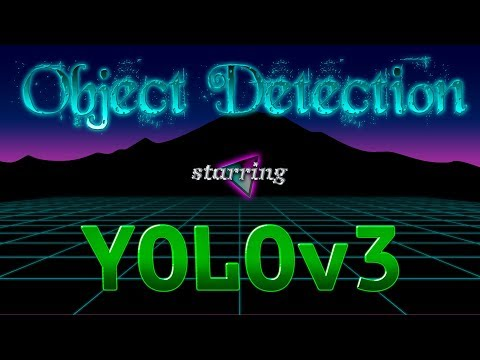

In [ ]:
from IPython.display import YouTubeVideo
# a talk about IPython at Sage Days at U. Washington, Seattle.
# Video credit: William Stein.
YouTubeVideo('MPU2HistivI')

#### YOLO 및 유사 모델
+ SSD: Single Shot MultiBox Detector
+ Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks

## 14.10 시멘틱 분할 (Semantic Segmentation)

픽셀이 속한 객체에 따른 픽셀 분류
+ 동일 분류의 객체는 서로 구별 되지 않음

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-33.png' width = 50%>

### 기본 아이디어
+ CNN의 단점 : stride가 2 이상인 경우 층이 깊어질수록 공간과 관련된 정보를 잃어버림

@ 객체 존재 정보는 알지만 위치정보는 잘못될 가능성
+ 객체의 위치 정보를 회복시킬 수 있어야 함
  + 업샘플링으로 이미지 크기 증폭

#### 업샘플링
전치합성곱 층을 사용해 업샘플링을 수행
+ 0으로 채워진 행과 열을 추가해 이미지를 늘림

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-34.png' width = 50% >

#### 스킵연결
+ 업샘플링만으로 제대로 된 정보 회복이 어려움
+ 스킵 연결로 풀링 과정에 잃은 정보를 회복시켜주면 학습에 많은 도움을 줌

<img src = 'https://formal.hknu.ac.kr/handson-ml2/slides/images/ch14/homl14-35.png' width = 70% >

+ R-CNN, Faster R-CNN